# **Pool detection - Exploratory Data Analysis**

Datasets obtenidos de:
- https://github.com/yacine-benbaccar/Pool-Detection
- https://www.kaggle.com/datasets/cici118/swimming-pool-detection-algarves-landscape

PLOTS https://www.data-to-viz.com/graph/parallel.html
https://www.data-to-viz.com/caveat/spider.html
https://www.kaggle.com/code/tarunpaparaju/plant-pathology-2020-eda-models

## **Librerías**

In [1]:
#%pip install scipy scikit-image scikit-learn numpy pandas matplotlib seaborn

In [1]:
import os
import random
import collections
import glob

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

## **Constantes**

In [2]:
DATA_DIR = os.path.join('..', 'data', 'datasets')
ALGARVES_DATASET_DIR = os.path.join(DATA_DIR, 'algarves', 'formatted_dataset')
YACINE_DATASET_DIR = os.path.join(DATA_DIR, 'yacine')

YACINE_SOURCE = 'yacine'
ALGARVES_SOURCE = 'algarves'

POSITIVE_LABEL = 'pools'
NEGATIVE_LABEL = 'no_pools'

La siguiente celda puede ser modificada para obtener resultados personalizados:

In [3]:
USE_CACHE = False 
PLOT_RESULTS = True
SEED = 42
random.seed(SEED)

### **Análisis del Conjunto de Datos**

In [4]:
def load_yacine_dataset(dataset_path: str, source=YACINE_SOURCE):
    df = collections.defaultdict(list)
    train_path = os.path.join(dataset_path, 'train')
    validation_path = os.path.join(dataset_path, 'validation')
    
    for split, split_path in [('train', train_path), ('validation', validation_path)]:
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)

            if not os.path.isdir(label_path):
                continue

            for image_filename in os.listdir(label_path):
                image_path = os.path.join(label_path, image_filename)
                df['split'].append(split)
                df['path'].append(image_path)
                df['source'].append(source)
                df['label'].append(label)

    return pd.DataFrame(df)

def load_algarves_dataset(dataset_path: str, source=ALGARVES_SOURCE):
    df = collections.defaultdict(list)
    for label in os.listdir(dataset_path):
        label_path = os.path.join(dataset_path, label)

        if not os.path.isdir(label_path):
            continue

        for image_filename in os.listdir(label_path):
            image_path = os.path.join(label_path, image_filename)
            df['split'].append(None)
            df['path'].append(image_path)
            df['source'].append(source)
            df['label'].append(label)

    return pd.DataFrame(df)

def load_datasets(yacine_dataset_path: str, algarves_dataset_path: str):
    df_yacine = load_yacine_dataset(yacine_dataset_path)
    df_algarves = load_algarves_dataset(algarves_dataset_path)
    datasets = [df_yacine, df_algarves]
    df = pd.concat(datasets, axis=0)
    return df

In [5]:
df = load_datasets(YACINE_DATASET_DIR, ALGARVES_DATASET_DIR)
df.head()

split                                               path  source     label
0  train    ..\data\datasets\yacine\train\no_pools\img0.jpg  yacine  no_pools
1  train   ..\data\datasets\yacine\train\no_pools\img10.jpg  yacine  no_pools
2  train  ..\data\datasets\yacine\train\no_pools\img100.jpg  yacine  no_pools
3  train  ..\data\datasets\yacine\train\no_pools\img1000...  yacine  no_pools
4  train  ..\data\datasets\yacine\train\no_pools\img1001...  yacine  no_pools

**Reordenar datos**

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED, shuffle=True, stratify=df['source']) # VER STRATIFY BUENA IDEA?
train_df, val_df = train_test_split(train_df, test_size=1/4, random_state=SEED, shuffle=True, stratify=train_df['source'])

In [7]:
tuple(np.array((len(train_df.index), len(val_df.index), len(test_df.index))) / len(df.index))

(0.5996435996435996, 0.20017820017820018, 0.20017820017820018)

**Tamaño de conjuntos**

In [8]:
train_df.groupby('source')['source'].count()

source
algarves     173
yacine      1846
Name: source, dtype: int64

In [9]:
train_df.groupby('source')['label'].value_counts()

source    label   
algarves  pools       107
          no_pools     66
yacine    pools       953
          no_pools    893
Name: count, dtype: int64

In [10]:
train_df['label'].value_counts()

label
pools       1060
no_pools     959
Name: count, dtype: int64

**Mostrar primeros datos**

In [11]:
def read_image(image_path: str):
    return cv2.imread(image_path)[..., ::-1]

In [12]:
train_images = [read_image(image_path) for image_path in train_df['path'].tolist()]
val_images = [read_image(image_path) for image_path in val_df['path'].tolist()]
test_images = [read_image(image_path) for image_path in test_df['path'].tolist()]
train_df['image'] = train_images
val_df['image'] = val_images
test_df['image'] = test_images

image_dimensions = [img.shape for img in train_images]
train_df['width'], train_df['height'], train_df['channels'] = list(zip(*image_dimensions))
train_df['pixel_number'] = train_df['width'] * train_df['height']
train_df['width_height_rate'] = train_df['width'] / train_df['height']

train_df.groupby('source')[['width', 'height', 'channels']].nunique()

width  height  channels
source                           
algarves     94     104         1
yacine        1       1         1

In [13]:
algarves_train_df = train_df[train_df['source']==ALGARVES_SOURCE]
yacine_train_df = train_df[train_df['source']==YACINE_SOURCE]

In [14]:
def plot_image_samples(images_rows: list[list], title: str):
    nrows = len(images_rows)
    ncols = len(images_rows[0])
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
    for row_idx, image_row in enumerate(images_rows):
        for col_idx, (image, label) in enumerate(image_row):
            ax[row_idx, col_idx].imshow(image)
            ax[row_idx, col_idx].set_title(label, fontsize=11)
            ax[row_idx, col_idx].axis('off')
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

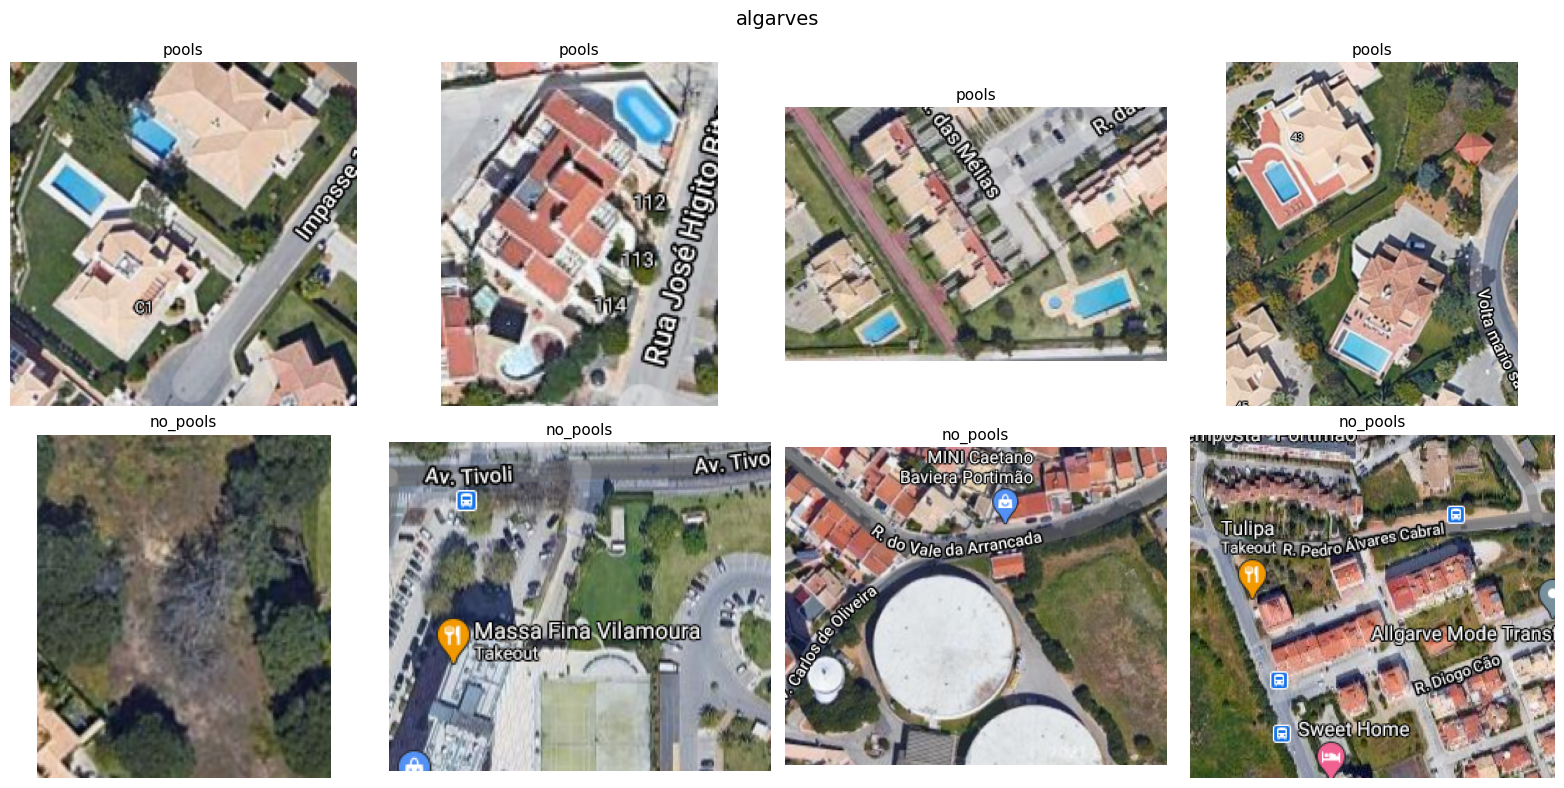

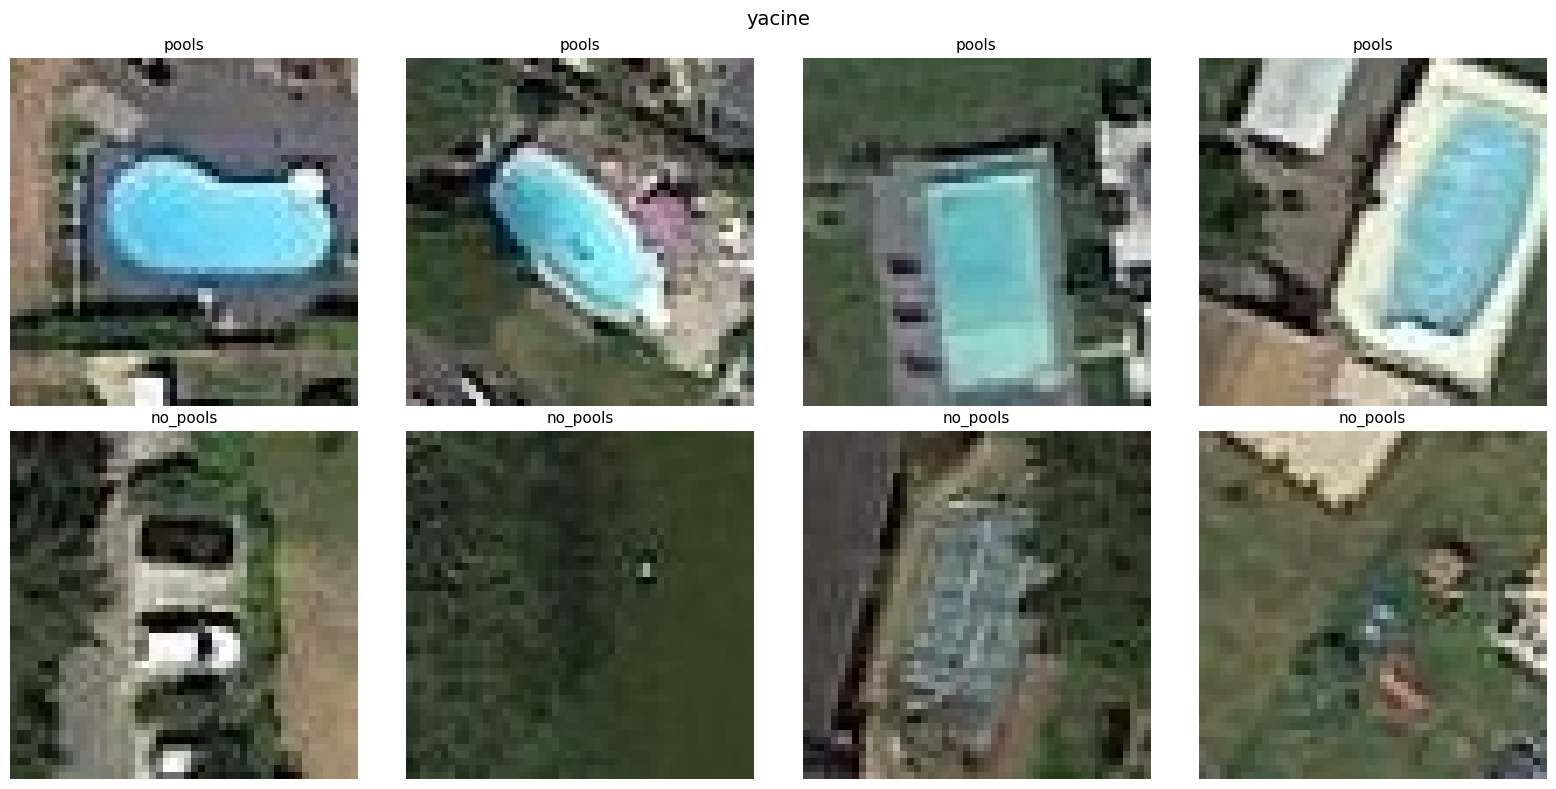

In [15]:
first_number = 8

if PLOT_RESULTS:
    for plot_df in [algarves_train_df, yacine_train_df]:
        source = plot_df['source'].tolist()[0]
        positive_images_dirs = [row for _, row in plot_df[plot_df['label']==POSITIVE_LABEL][['image', 'label']][:first_number//2].iterrows()]
        negative_images_dirs = [row for _, row in plot_df[plot_df['label']==NEGATIVE_LABEL][['image', 'label']][:first_number//2].iterrows()]
        first_images = [positive_images_dirs, negative_images_dirs]
        plot_image_samples(first_images, source)
    

**Tamaño de imágenes**

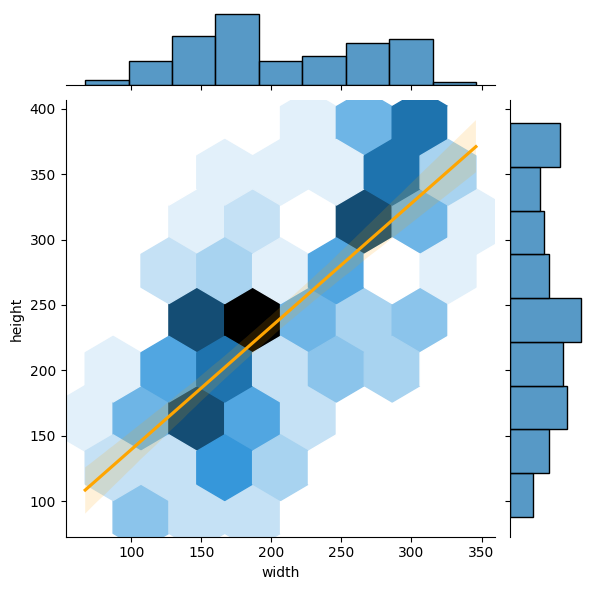

In [16]:
g = sns.jointplot(data=algarves_train_df, x='width', y='height', kind="hex")
sns.regplot(data=algarves_train_df, x='width', y='height', scatter=False, ax=g.ax_joint, color='orange')
plt.show()

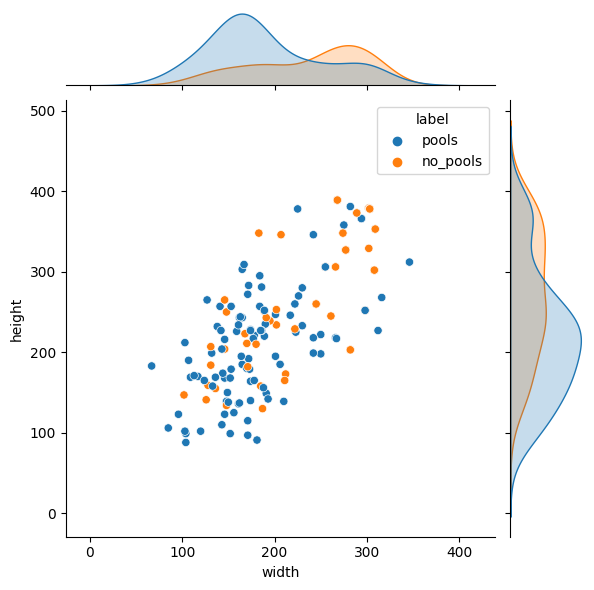

In [17]:
sns.jointplot(data=algarves_train_df, x='width', y='height', hue='label');

f:\AlexisF\python\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


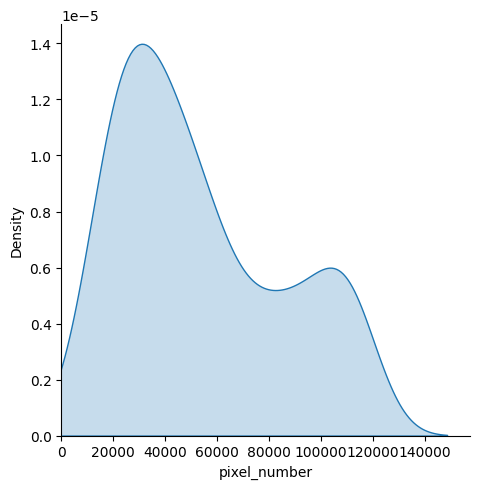

In [18]:
sns.displot(algarves_train_df['pixel_number'], kind='kde', fill=True).set(xlim=(0));

f:\AlexisF\python\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


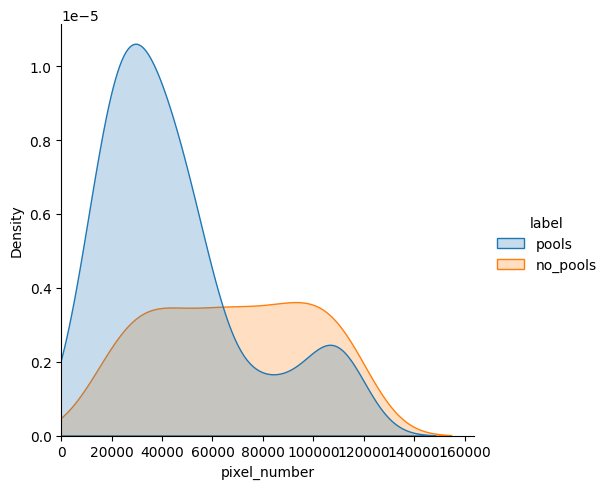

In [19]:
sns.displot(data=algarves_train_df, x='pixel_number', kind='kde', hue='label', fill=True).set(xlim=(0));

**Imágenes más grandes:**

In [20]:
def get_size_dfs(df: pd.DataFrame, head):
    more_pixeles_df = df.sort_values(by='pixel_number',ascending=True).head(head)
    less_pixeles_df = df.sort_values(by='pixel_number',ascending=False).head(head)
    biggest_width_df = df.sort_values(by='width_height_rate',ascending=False).head(head)
    biggest_height_df = df.sort_values(by='width_height_rate',ascending=True).head(head)
    return more_pixeles_df, less_pixeles_df, biggest_width_df, biggest_height_df

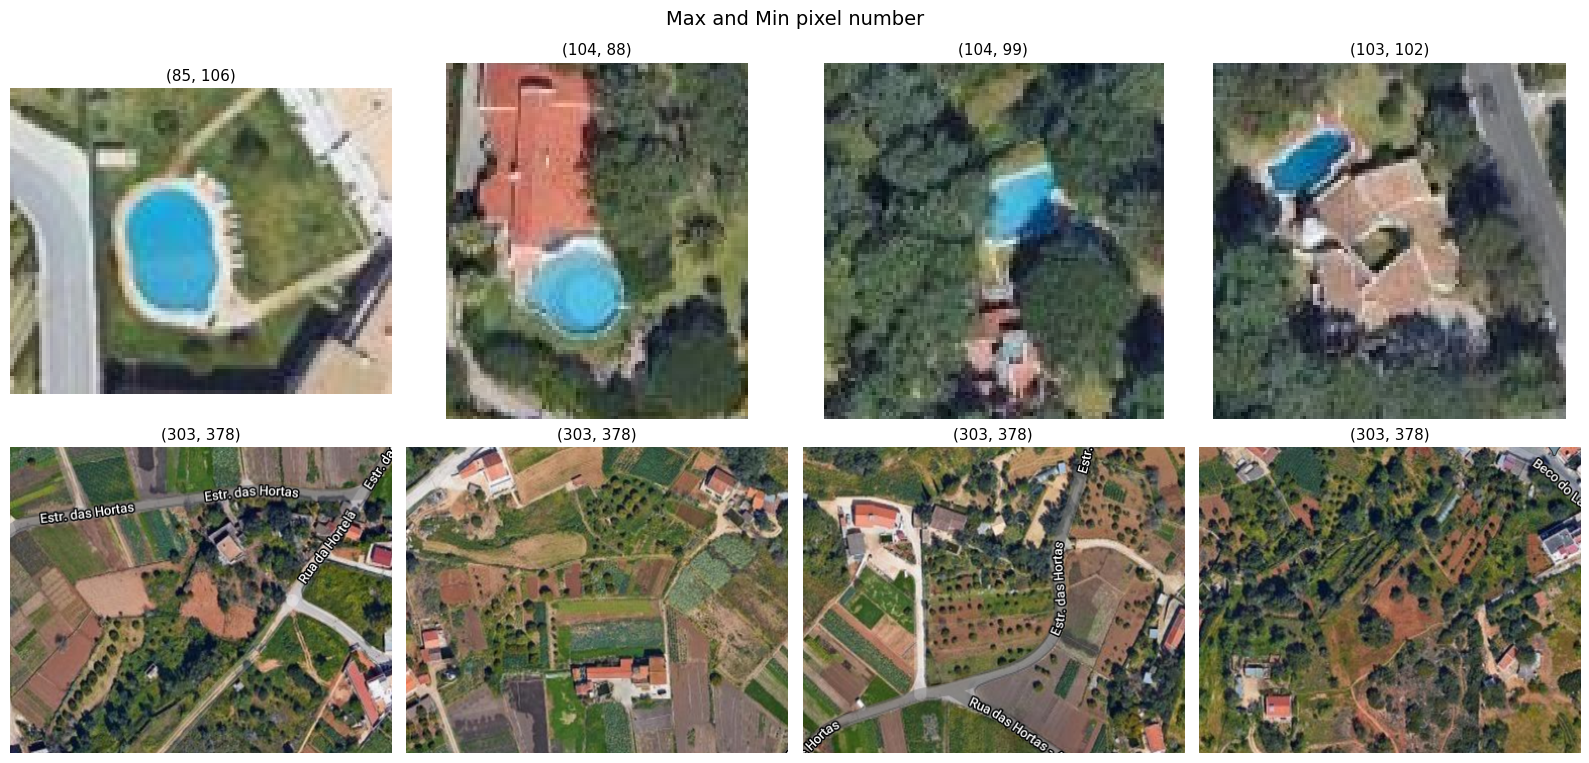

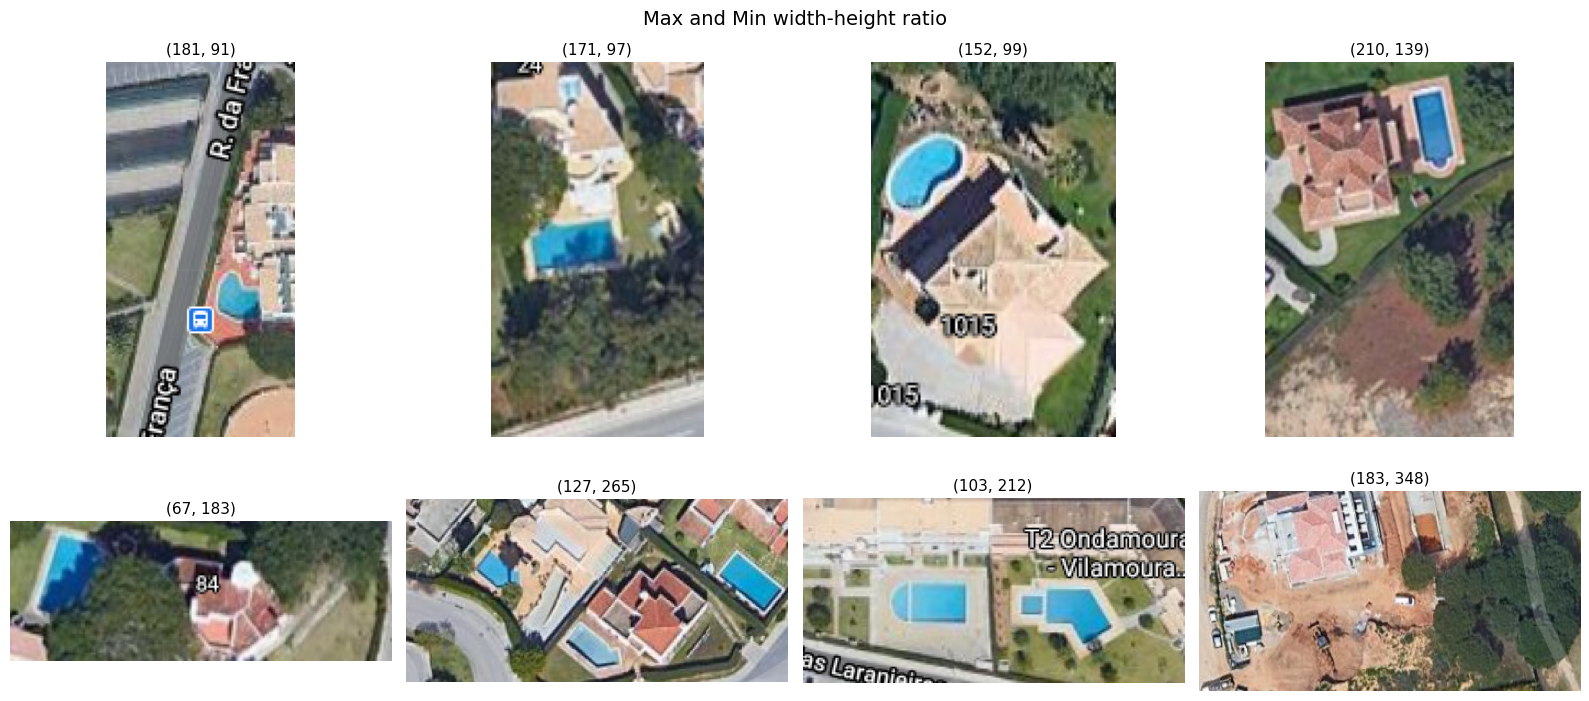

In [21]:
n_shown = 4
more_pixeles_df, less_pixeles_df, biggest_width_df, biggest_height_df = get_size_dfs(algarves_train_df, head=n_shown)
pixels_n_dfs = [more_pixeles_df, less_pixeles_df]
width_height_rate_dfs = [biggest_width_df, biggest_height_df]
format_image_and_title = lambda img_df: list(zip(img_df["image"].tolist(), 
                                             zip(img_df["width"].tolist(), 
                                                 img_df["height"].tolist())))

pixels_n_images = [format_image_and_title(img_df) for img_df in pixels_n_dfs]
width_height_images = [format_image_and_title(img_df) for img_df in width_height_rate_dfs]
plot_image_samples(pixels_n_images, title="Max and Min pixel number")
plot_image_samples(width_height_images, title="Max and Min width-height ratio")

## PCA AND CLUSTERING

In [22]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

common_size = (50, 50)
clusteded_df = train_df# algarves_train_df #yacine_train_df# 
images = [cv2.resize(img, common_size) for img in clusteded_df["image"]]
labels = clusteded_df["label"].to_numpy()
image_vectors = [img[..., 2].flatten() for img in images]
X = np.array(image_vectors)

In [23]:
n_components = 2
pca = PCA(n_components=n_components)
reduced_X = pca.fit_transform(X)

n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
cluster_labels = kmeans.fit_predict(reduced_X)

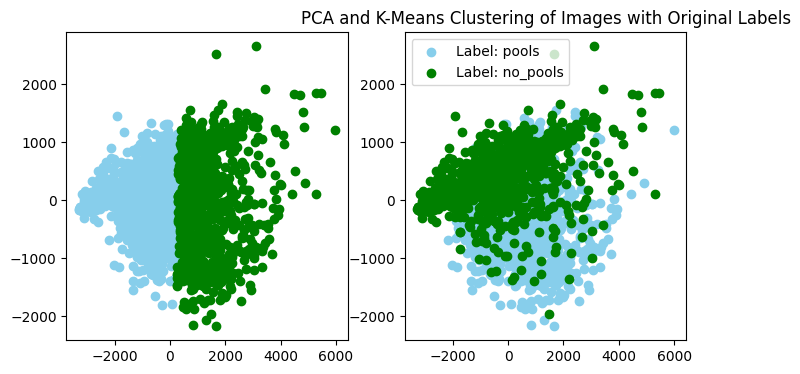

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
colors = ['skyblue', 'g']

for i in range(n_clusters):
    cluster_images = np.array(images)[cluster_labels == i]
    cluster_labels_original = np.array(labels)[cluster_labels == i]
    ax[0].scatter(
        reduced_X[cluster_labels == i, 0],
        reduced_X[cluster_labels == i, 1],
        c=colors[i],
        label=f'Cluster {i + 1}'
    )

for i, label in enumerate([POSITIVE_LABEL, NEGATIVE_LABEL]):
    ax[1].scatter(
        reduced_X[labels == label, 0],
        reduced_X[labels == label, 1],
        c=colors[i],
        label=f'Label: {label}'
    )

plt.title('PCA and K-Means Clustering of Images with Original Labels')
plt.legend()
plt.show()

C:\Users\Alexis\AppData\Local\Temp\ipykernel_7472\266331442.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_images = np.array(cluster_images)


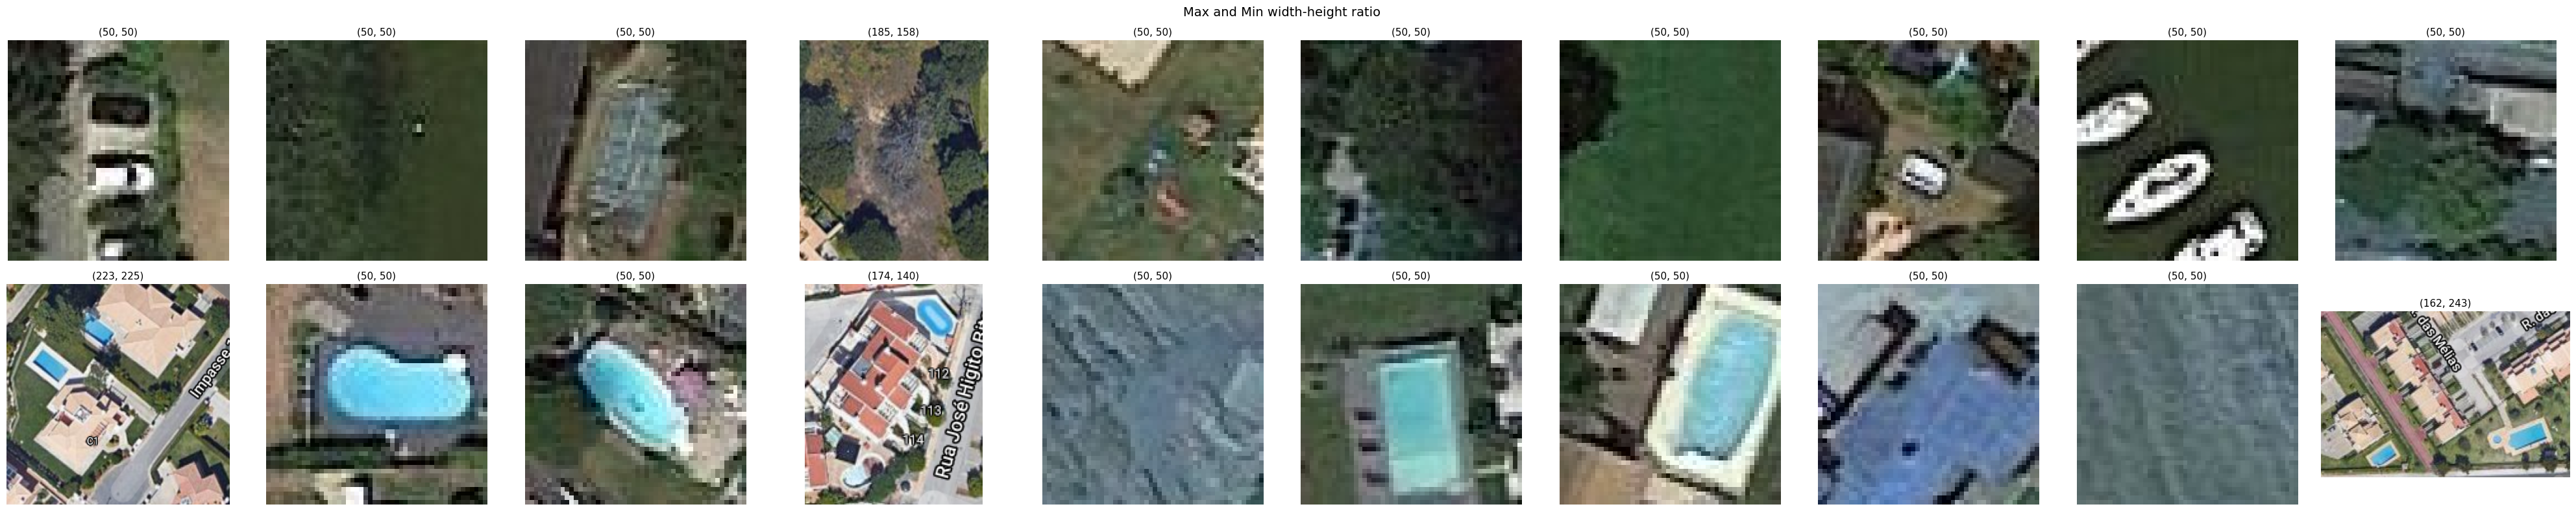

In [25]:
cluster_images = format_image_and_title(clusteded_df)
cluster_images = np.array(cluster_images)

shown_images = 10
cluster_images_0 = cluster_images[cluster_labels == 0][:shown_images]
cluster_images_1 = cluster_images[cluster_labels == 1][:shown_images]
cluster_images = [cluster_images_0, cluster_images_1] 

plot_image_samples(cluster_images, title="Max and Min width-height ratio")


In [26]:
from sklearn.metrics import rand_score

label_indices = np.where(labels==POSITIVE_LABEL, 1, 0)
rand_index = rand_score(label_indices, cluster_labels)
print(f"Adjusted Rand Index: {rand_index:.4f}")

Adjusted Rand Index: 0.5107


In [27]:
sum(abs(label_indices-cluster_labels))

860

### **Aumentación de datos** (PENDIENTE)

In [28]:
augmentation_functions = {
    'rotate': lambda image: rotate(image, random.randint(0, 360)),
    'noise': lambda image: random_noise(image),
    'gamma': lambda image: exposure.adjust_gamma(image, random.uniform(0.5, 1.5)),
    'gaussian': lambda image: gaussian(image),
}

def augment_images(
    images, 
    augment_rate=0.2,
    rotation_factor=0.05,
    noise_factor=0.025,
    gamma_factor=0.025,
    gaussian_factor=0.1,
):
    augmentation_rates = [rotation_factor, noise_factor, gamma_factor, gaussian_factor]
    rates = sum(augmentation_rates)
    if rates != augment_rate:
        print('Warning: Augment rate is not equal to sum of augmentation rates')
        gaussian_factor += augment_rate - rates

    augmented_images = []
    for (image_dir, image, label) in images:
        if random.random() < augment_rate:
            function = random.choices(
                list(augmentation_functions.keys()), 
                weights=[rotation_factor, noise_factor, gamma_factor, gaussian_factor]
            )[0]
            augmented_image = augmentation_functions[function](image)
            min_image, max_image = np.min(augmented_image), np.max(augmented_image)
            augmented_image = ((augmented_image - min_image) / (max_image - min_image)) * 255
            augmented_image = augmented_image.astype(np.uint8)
            augmented_images.append((image_dir, augmented_image, label, image))
    return augmented_images

In [29]:
augmented_train_images = augment_images(train_images)

ValueError: too many values to unpack (expected 3)

In [ ]:
def compare_augmented_images(augmented_images, showed_images=5):
    fig, ax = plt.subplots(2, showed_images, figsize=(12, 5))
    for idx, (_, image, label, original_image) in enumerate(augmented_images[:showed_images]):
        ax[0, idx].imshow(image)
        ax[1, idx].set_title(f'{label}')
        ax[0, idx].axis('off')

        ax[1, idx].imshow(original_image)
        ax[0, idx].set_title(f'Augmented')
        ax[1, idx].axis('off')
    plt.tight_layout()

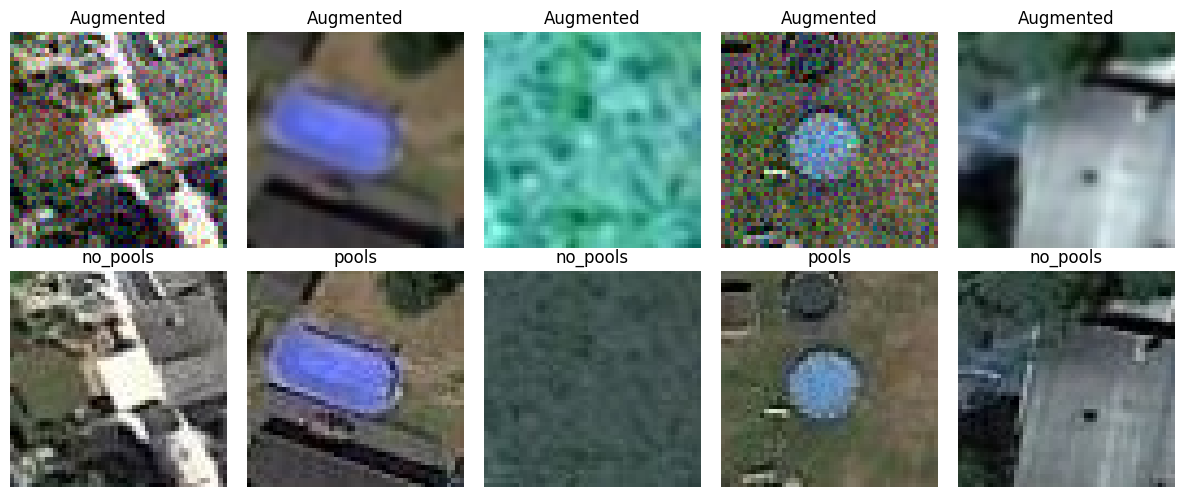

In [ ]:
if PLOT_RESULTS:
    compare_augmented_images(augmented_train_images)

### **Prueba con clasificadores**

TODO: ADD RESHAPE + ADD LABEL + EARLY STOPPING

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.optimizers import Adam

def build_model(img_width: int, img_height: int, n_classes=2, freeze=True):
    model = Sequential()

    pretrained_model= tf.keras.applications.ResNet50(
                        include_top=False,
                        input_shape=(img_height,img_width,3),
                        pooling='avg',
                        classes=n_classes,
                        weights='imagenet'
                    )

    if freeze:
        for layer in pretrained_model.layers:
                layer.trainable=False

    model.add(layers.Rescaling(1./255,input_shape=(img_width,img_height,3)))
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))

    activation = 'sigmoid' if n_classes ==2 else 'softmax'
    model.add(Dense(n_classes if n_classes > 2 else 1, activation=activation))
    model_loss = 'binary_crossentropy' if n_classes == 2 else 'categorical_crossentropy'
    model.compile(optimizer=Adam(learning_rate=0.001),loss=model_loss,metrics=['accuracy'])
    return model

In [ ]:
image_size = (100, 100)
model = build_model(*image_size)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_12 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 1)                513       
 apper)                                                          
                                                      

In [ ]:
def prepare_dataset(images: np.ndarray, labels: list[str], size: tuple[int], batch_size=32, seed=SEED, positive_label=POSITIVE_LABEL):
    images = list(map(lambda image: cv2.resize(image, size), images))
    labels = np.where(labels==positive_label, 1, 0)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    shuffle_buffer_size = len(images)
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset

train_ds = prepare_dataset(train_df["image"], train_df["label"], size=image_size)
val_ds = prepare_dataset(val_df["image"], val_df["label"], size=image_size)
test_ds = prepare_dataset(test_df["image"], test_df["label"], size=image_size)

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/10


64/64 [==============================] - 63s 900ms/step - loss: 0.7498 - accuracy: 0.5518 - val_loss: 0.7752 - val_accuracy: 0.5386
Epoch 2/10
64/64 [==============================] - 49s 777ms/step - loss: 0.6648 - accuracy: 0.5978 - val_loss: 0.6256 - val_accuracy: 0.6558
Epoch 3/10
64/64 [==============================] - 47s 738ms/step - loss: 0.6386 - accuracy: 0.6424 - val_loss: 0.6489 - val_accuracy: 0.5519
Epoch 4/10
64/64 [==============================] - 45s 705ms/step - loss: 0.6106 - accuracy: 0.6830 - val_loss: 0.6019 - val_accuracy: 0.6350
Epoch 5/10
64/64 [==============================] - 47s 738ms/step - loss: 0.6254 - accuracy: 0.6612 - val_loss: 0.6726 - val_accuracy: 0.6825
Epoch 6/10
64/64 [==============================] - 52s 811ms/step - loss: 0.6061 - accuracy: 0.6909 - val_loss: 0.5810 - val_accuracy: 0.7404
Epoch 7/10
64/64 [==============================] - 48s 749ms/step - loss: 0.5807 - accuracy: 0.7048 - val_loss: 0.5722 - val_accuracy: 0.6899
Epoch 8/10

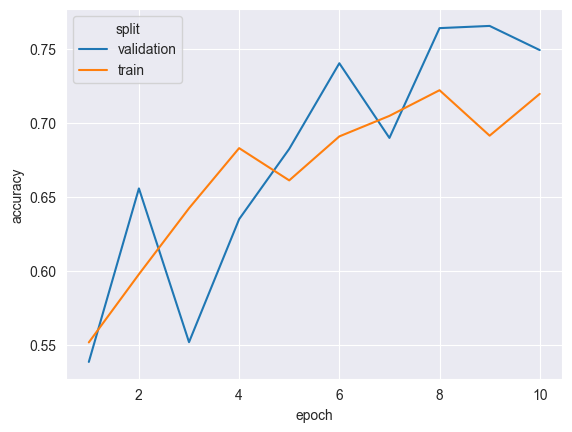

In [ ]:
data = {'epoch': [], 'accuracy': [], 'split': []}
for idx, val_acc in enumerate(history.history['val_accuracy']):
  data['split'].append('validation')
  data['accuracy'].append(val_acc)
  data['epoch'].append(idx+1)
for idx, train_acc in enumerate(history.history['accuracy']):
  data['split'].append('train')
  data['accuracy'].append(train_acc)
  data['epoch'].append(idx+1)

sns.set_style('darkgrid')
sns.lineplot(data=data, x='epoch', y='accuracy', hue='split');

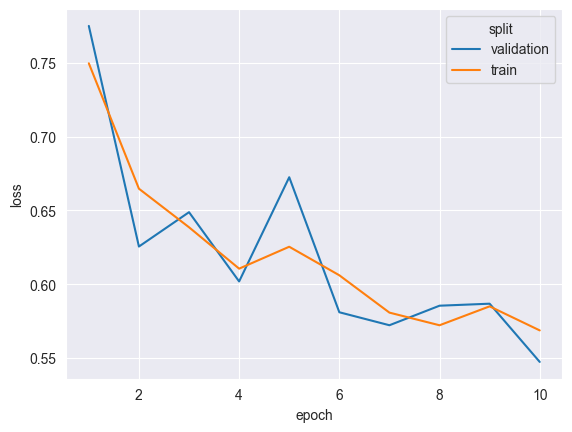

In [ ]:
data = {'epoch': [], 'loss': [], 'split': []}
for idx, val_loss in enumerate(history.history['val_loss']):
  data['split'].append('validation')
  data['loss'].append(val_loss)
  data['epoch'].append(idx+1)
for idx, train_loss in enumerate(history.history['loss']):
  data['split'].append('train')
  data['loss'].append(train_loss)
  data['epoch'].append(idx+1)

sns.set_style('darkgrid')
sns.lineplot(data=data, x='epoch', y='loss', hue='split');